# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [17]:
# Import all the libraries and/or dependencies
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Import Libraries Social Sentiment analysis
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import plotly.graph_objects as go

from dotenv import load_dotenv
load_dotenv()

import datetime
import panel as pn
pn.extension('plotly')
import hvplot.pandas
%matplotlib inline
import plotly.express as px
import matplotlib.pyplot as plt
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed
from panel.interact import interact
import yfinance as yf

In [2]:
 #your Twitter API key and API secret & Microsoft Azure API Credentials
consumerKey = os.getenv("twitter_api_key")
consumerSecret = os.getenv("twitter_secret_api_key")
accessToken = os.getenv("twitter_access")
accessTokenSecret = os.getenv("twitter_access_secret")

# authenticate
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [3]:
#Sentiment Analysis
def  percentage(part,whole):
    return 100 * float(part)/float(whole) 

#keyword = input("Please enter keyword or hashtag to search: ")
#noOfTweet = int(input ("Please enter how many tweets to analyze: "))
noOfTweet = 5
hashtag =  pd.read_csv(Path('StockUniverse.csv',header=None,))
ticker_lst = hashtag["Tickers"].values.tolist()


In [4]:
def get_tweets_senti(ticker_lst, noOfTweet):
    tick_lst = []
    senti_rating = []
    tweets_df = pd.DataFrame()

    for ticker in ticker_lst:
        search_qry = '$' + ticker + "-filter:retweets"
        #keyword = '$' + ticker
        tweets = tweepy.Cursor(api.search_tweets, q=search_qry, lang = 'en').items(noOfTweet)
        positive  = 0
        negative = 0
        neutral = 0
        polarity = 0
        tweet_list = []
        neutral_list = []
        negative_list = []
        positive_list = []

        for tweet in tweets:
            tweet_list.append(tweet.text)
            analysis = TextBlob(tweet.text)
            score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
            neg = score['neg']
            neu = score['neu']
            pos = score['pos']
            comp = score['compound']
            polarity += analysis.sentiment.polarity

            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1

            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1

            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1

        positive = percentage(positive, noOfTweet)
        negative = percentage(negative, noOfTweet)
        neutral = percentage(neutral, noOfTweet)
        polarity = percentage(polarity, noOfTweet)
        positive = format(positive, '.1f')
        negative = format(negative, '.1f')
        neutral = format(neutral, '.1f')
        
        #Number of Tweets (Total, Positive, Negative, Neutral)
          
        neutral_list = pd.DataFrame(neutral_list)
        negative_list = pd.DataFrame(negative_list)
        positive_list = pd.DataFrame(positive_list)
        
        # if positve sentiment is greater than 50 then score is 10,  extremly positve 
        # if neutral is greater than 50 and Positive is greater than negative then score is 7,  moderately postive
        # if neutral is greater than 50 and Positive is less than negative then score is 3,  moderately negative
        # if negative is greater than 50 then score is 1, extremly negative
        positive_score = float(positive)
        neutral_score = float(neutral)
        negative_score = float(negative)
        
        if positive_score > 50:
            tick_lst.append(ticker)
            senti_rating.append(10)
        elif negative_score > 50:
            tick_lst.append(ticker)
            senti_rating.append(1)
        elif positive_score == negative_score:
            tick_lst.append(ticker)
            senti_rating.append(5)        
        elif positive_score > negative_score:
            tick_lst.append(ticker)
            senti_rating.append(7)
        elif positive_score < negative_score:
            tick_lst.append(ticker)
            senti_rating.append(3)   
          
  
    # create and return the sentiment score dataframe
    sentiment_score_df = pd.DataFrame()
    sentiment_score_df = create_senti_score_df(tick_lst, senti_rating)
    # create and return the sentiment score dataframe
    return sentiment_score_df

In [5]:
def create_senti_score_df(ticker_lst, senti_rating):
    print(ticker_lst)
    print(senti_rating)
    df_struct = {'Ticker' : ticker_lst, 'Score' : senti_rating}
    
    #create sentiment score dataframe
    senti_score_df = pd.DataFrame(df_struct)
    senti_score_df.to_csv('senti_score.csv', encoding='utf-8')
    # reutrn the sentiment score dataframe
    return senti_score_df 
            

In [6]:
# call the twitter API to get the sentiment data
senti_score_df = get_tweets_senti(ticker_lst, noOfTweet)

['AMD', 'NFLX', 'HD', 'GOOG', 'CRM', 'PYPL', 'MSFT', 'APA', 'GM', 'NVAX', 'DIS', 'SQ', 'AMZN', 'FB', 'MRVL', 'NVDA', 'GME', 'AAPL', 'BABA', 'TSLA']
[10, 7, 3, 7, 10, 7, 10, 10, 7, 3, 10, 7, 5, 7, 5, 7, 7, 7, 10, 7]


In [7]:
senti_score_df = senti_score_df.sort_values('Score', ascending=False)
senti_score_df

,Ticker,Score
0,AMD,10
6,MSFT,10
18,BABA,10
7,APA,10
10,DIS,10
4,CRM,10
5,PYPL,7
3,GOOG,7
8,GM,7
1,NFLX,7


In [8]:
def yahoo_finance(ticker_lst):
    port_df = yf.download(ticker_lst, start='2009-12-07', end='2021-12-07',interval = '1d')
    return port_df

In [9]:
#for top ticker with highest positive social sentiment. Call the yahoo finance API to get the stock data
yahoo_df = yahoo_finance(senti_score_df.iloc[0][0])

[*********************100%***********************]  1 of 1 completed


In [10]:
#adj_close_df = df.loc[:,['Adj Close']]
adj_close_df = yahoo_df.filter(['Adj Close'])
adj_close_df.dropna(inplace = True)
adj_close_df

,Adj Close
Date,
2009-12-07,8.520000
2009-12-08,8.670000
2009-12-09,8.710000
2009-12-10,8.580000
2009-12-11,8.640000
...,...
2021-11-30,158.369995
2021-12-01,149.110001
2021-12-02,150.679993


In [11]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window -1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]

        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

# Predict Closing Prices using a 9 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 1 is the 'fng_value' column - add when we have Sentiment data
# Column index 0 is the `Close` column
feature_column = 0
target_column = 0
X, y = window_data(adj_close_df, window_size, feature_column, target_column)


# Use 70% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2713, 5)
(302, 5)
(2713, 1)
(302, 1)


In [12]:
# Use the MinMaxScaler to scale data between 0 and 1.
X_scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
X_scaler.fit(X_train)

# Scale the features training and testing sets
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)

# Scale the target training and testing sets
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)


# Reshape the features for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape

(2713, 5, 1)

## Build and Train the LSTM RNN

Design a custom LSTM RNN and fit (train) it using the training data.

Steps needed to:
- Define the model architecture
- Compile the model
- Fit the model to the training data

In [13]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()
number_units = 76
dropout_fraction = 0.27

# layer 1
model.add(LSTM(units=number_units, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units-10, activation='relu',  return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units-10, activation='relu', return_sequences=True))
#model.add(Dropout(dropout_fraction))

# Layer 4
model.add(LSTM(units=number_units-5, activation='relu', return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 5
model.add(LSTM(units=number_units-5, activation='relu'))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))


# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])


# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 76)             23712     
                                                                 
 dropout (Dropout)           (None, 5, 76)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 66)             37752     
                                                                 
 dropout_1 (Dropout)         (None, 5, 66)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 66)             35112     
                                                                 
 lstm_3 (LSTM)               (None, 5, 71)             39192     
                                                                 
 dropout_2 (Dropout)         (None, 5, 71)             0

Wall time: 49.9 s


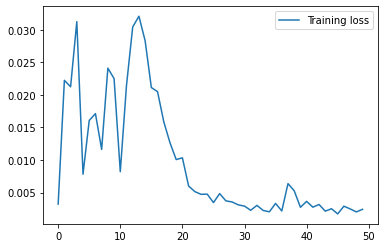

In [14]:
%%time
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
history = model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=16, verbose=0)

plt.plot(history.history['loss'], label='Training loss')
#plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### Checking Model Performance

Evaluate the model using the test data. 

Steps needed to:
- Evaluate the model using the `X_test` and `y_test` data.
- Use the X_test data to make predictions
- Create a DataFrame of Real (y_test) vs predicted values. 
- Plot the Real vs predicted values as a line chart

Apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

10/10 [==============================] - 0s 2ms/step - loss: 0.0219 - mse: 0.0219


:NdOverlay   [Variable]
   :Curve   [Date]   (value)

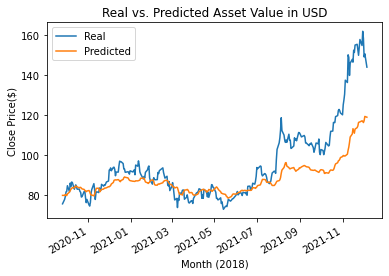

In [15]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Make some predictions
predicted = model.predict(X_test)
rmse = np.sqrt(np.mean(((predicted - y_test) **2)))
rmse

# Recover the original prices instead of the scaled version
predicted_prices = y_scaler.inverse_transform(predicted)
real_prices = y_scaler.inverse_transform(y_test.reshape(-1, 1))


# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = yahoo_df.index[-len(real_prices): ]) 
stocks

# Plot the real vs predicted values as a line chart
stocks.plot(xlabel="Month (2018)", ylabel="Close Price($)", title="Real vs. Predicted Asset Value in USD");

stocks.hvplot()

In [22]:
#close_data = adj_close_df.reshape((-1))

def predict(look_back, num_prediction, model):
    close_data = adj_close_df['Adj Close'].values
    close_data = close_data.reshape((-1,1))
    prediction_list = close_data[-look_back:]
    print(prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
       # print(x)
        out = model.predict(x)
        prediction_list = np.append(prediction_list, out)
    prediction = prediction_list[look_back-1:]
    print(f"Prediction ---->> {prediction} "   )
    return prediction
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

def predict_dates(df, num_prediction):
    ycopy_df = adj_close_df.copy()
    ycopy_df.reset_index(inplace=True)
    last_date = ycopy_df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1, freq=us_bd)
    #prediction_dates.freq=None #.tolist()
    return prediction_dates.tolist()
    

num_prediction = 2
look_back = 5
forecast = predict(look_back,num_prediction, model)
forecast_dates = predict_dates(stocks, num_prediction)

[[158.36999512]
 [149.11000061]
 [150.67999268]
 [144.00999451]
 [139.05999756]]
Prediction ---->> [ 139.05999756 1069.43029785 1101.24072266] 


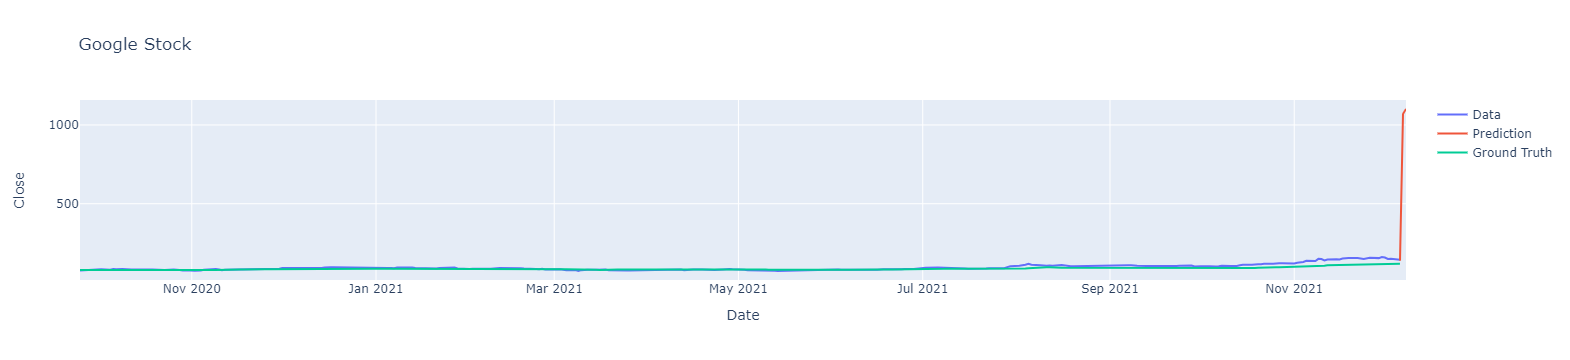

In [23]:
forecast_df = pd.DataFrame({"Dates":forecast_dates, "Future_Values":forecast}) 
forecast_df

#prediction = model.predict(test_generator)

close_train = stocks.Real
date_test = stocks.index
pred_test = stocks.Predicted
prediction = forecast_df.Future_Values
pred_dates = forecast_df.Dates
pred_dates
trace1 = go.Scatter(
    x = date_test,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = pred_dates,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = pred_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Google Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()
